In [1]:
## Find keas by name

In [61]:
import pandas as pd
import requests
import json

In [62]:
url = "https://data.keadatabase.nz/band_combos/?style=&study_area=&bird__status=alive&colours=&symbols=&is_extended=true&is_featured=unknown"

In [63]:
def get_keas(url = ""):
    response = requests.get(url).json()
    
    if response['results']:
        df = pd.io.json.json_normalize(response['results'])
        df.columns = df.columns.map(lambda x: x.split(".")[-1])
 
    else:
        print('no data')
    if response['next']:
        df = pd.concat([df,  get_keas(response['next'])], ignore_index=True,sort=False)
         
    return df

In [64]:
keas = get_keas(url)

In [73]:
print(keas.shape)
print(keas.columns)
print(keas.dtypes)
keas = keas.loc[:,~keas.columns.duplicated()]


(228, 29)
Index(['band_combo', 'description', 'is_featured', 'full_size', 'large',
       'thumbnail', 'profile_picture_attribution', 'sponsor_name',
       'sponsor_website', 'birthday', 'date_imported', 'date_modified',
       'get_age', 'get_life_stage', 'name', 'primary_band', 'sex', 'slug',
       'status', 'study_area', 'colours', 'date_deployed', 'date_imported',
       'date_modified', 'name', 'special', 'study_area', 'style', 'symbols'],
      dtype='object')
band_combo                     object
description                    object
is_featured                    bool  
full_size                      object
large                          object
thumbnail                      object
profile_picture_attribution    object
sponsor_name                   object
sponsor_website                object
birthday                       object
date_imported                  object
date_modified                  object
get_age                        int64 
get_life_stage                 ob

In [74]:
keas.head()

band_combo  \
0  Red o on White      
1  White C on Orange   
2  Yellow * on Black   
3  x / x - Metal / x   
4  White S on Red      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            description  \
0  Addi was one of ten kea banded at Moturau hut on the Kepler Track during August 2019. She is a young female who is found hanging out in a very large (20+) circus of kea around the area. Addi is named after the young daughter of Monique - a local Department of Conservation ranger in Te Anau who came out to the hut for the night to help with the kea work.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1  Two kea were caught together at Red Tarns on the slopes of Mt Sebastapol in mid-March 2019. These two young birds, most likely brother and sister, were named Scotty and Adriana after a wonderful couple from the area who have been heavily involved in conservation for many years. \r\n\r\nScott Theobold died tragically in a helicopter accident in Oct 2018, along with two others (Paul Hondelink and pilot Nick Wallis). We dedicate this to Scotty, Adriana and their family and recognise that what Scott has achieved in conservation progress has been tremendous. His work includes pioneering the use of predator detection dogs in NZ. His first work was training dogs to detect stoats - one of the kea's biggest predators. \r\n\r\nAdriana came to help out with some kea catching with us and Corey Mosen (the kea guru) at Red Tarns a year or so back, and was one of the most wonderful, enthusiastic, positive people you will ever meet. Our thoughts and best wishes are with Adriana and family and long may you continue with your good work. Kia kaha.   
2  Alwyn hangs out mostly at Deaths Corner and Candys Bend. She was banded by Corey Mosen in August 2016. We expect her to start nesting in the next couple of years. She is the current bird on the home page  of the Kea Database!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [76]:
keas['study_area'].value_counts()

Waimakariri    142
Fiordland      34 
Willowbank     12 
Wanaka         9  
Westland       8  
Orana Park     7  
Aoraki         6  
Rotoiti        5  
Kahurangi      3  
Wakatipu       1  
Mt Richmond    1  
Name: study_area, dtype: int64

In [97]:
import numpy as np
kea_df = keas.dropna(subset=['thumbnail'])
kea_df.sex.value_counts()

Male            150
Female          68 
Undetermined    6  
Name: sex, dtype: int64

In [151]:
import urllib.request
import urllib.parse as parse

kea_df = kea_df[(kea_df.sex == 'Male') | (kea_df.sex == 'Female')]

In [160]:
for index, row  in kea_df.iterrows():
    sex = "female"
    if row['sex'] == "Male":
        sex = "male"
    filename = parse.urlsplit(row.thumbnail).path.split("/")[-1]
    urllib.request.urlretrieve(row.thumbnail, f"images/{sex}/{filename}")


In [170]:
from fastai.vision import *
tfms = get_transforms(do_flip=False)
data = (ImageList.from_folder('images')
        .split_by_folder()          
        .label_from_folder()
        .add_test_folder('test')
        .transform(tfms, size=250)
        .databunch()
        .normalize(imagenet_stats)) 

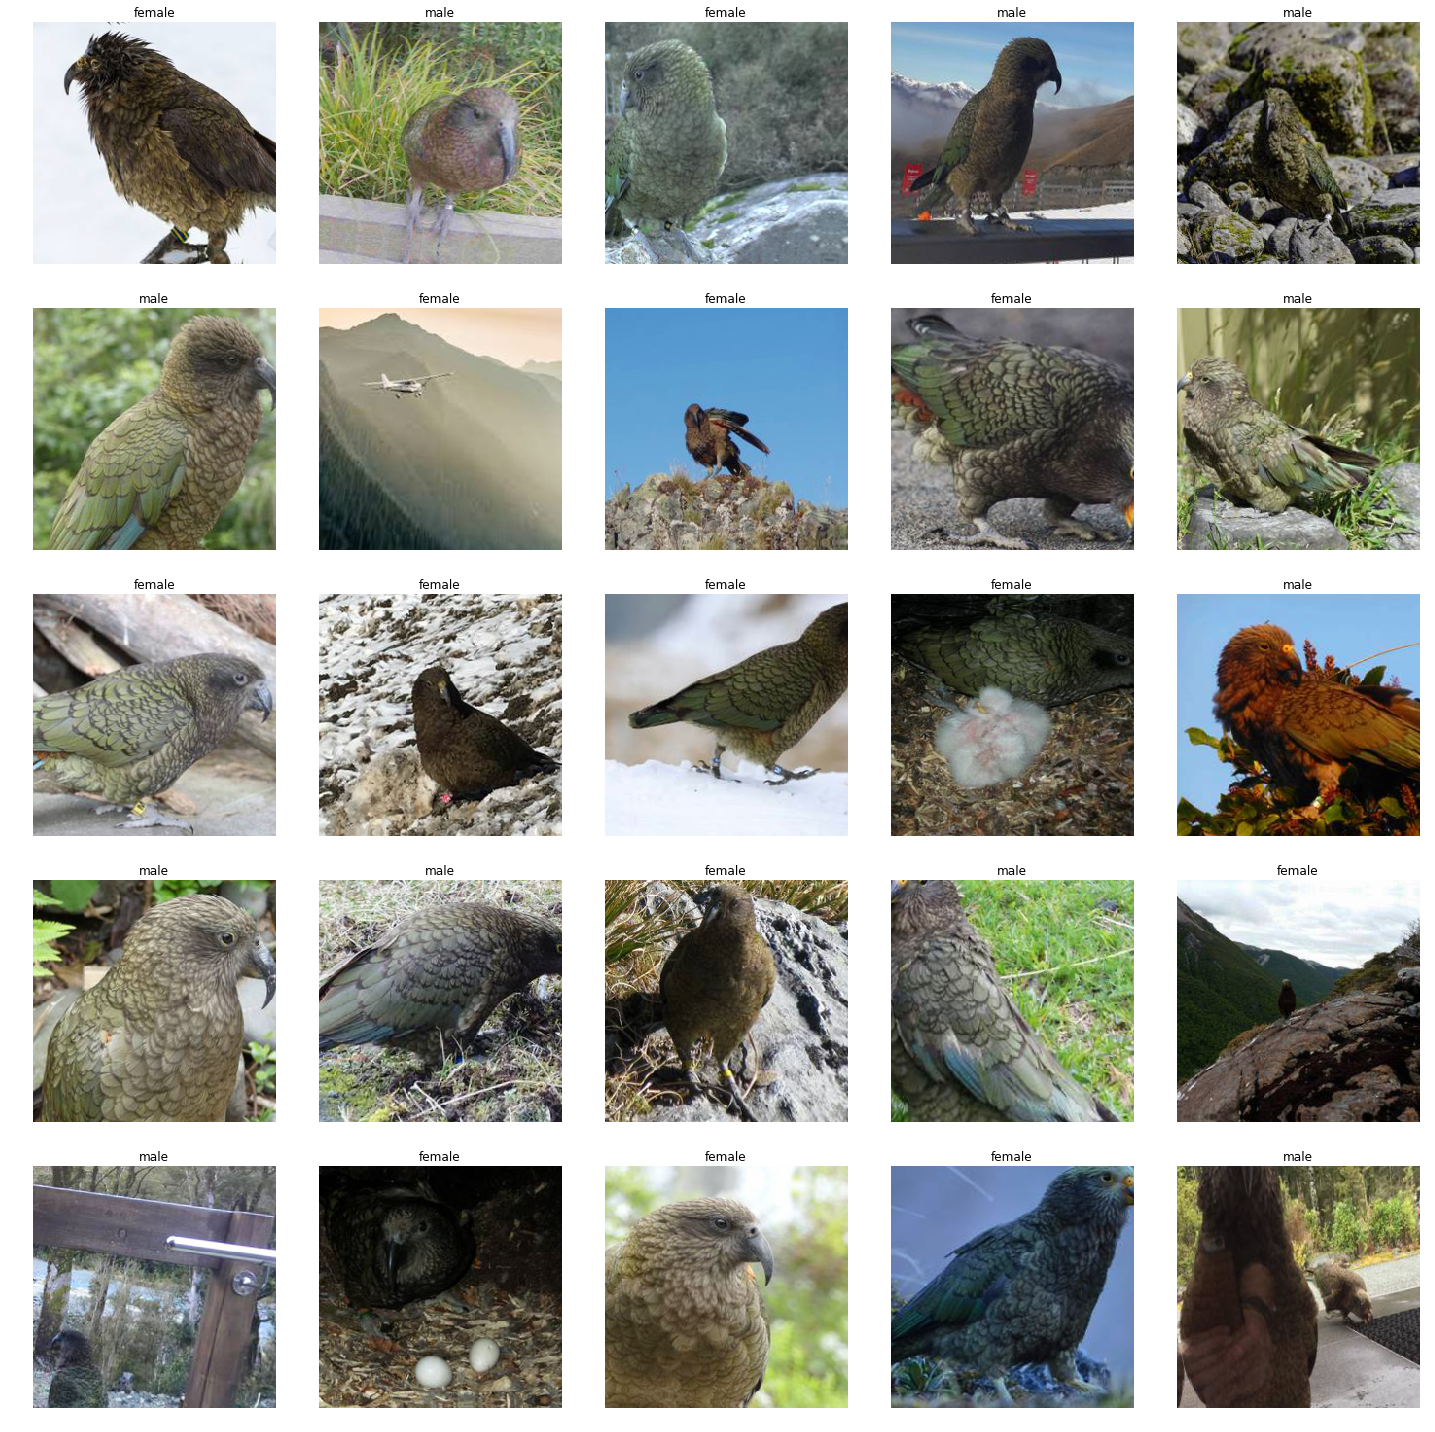

In [171]:
data.show_batch()

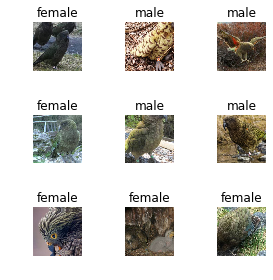

In [172]:
data.show_batch(rows=3, figsize=(4,4))

In [173]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(3,1e-2)
learn.save('mini_train')

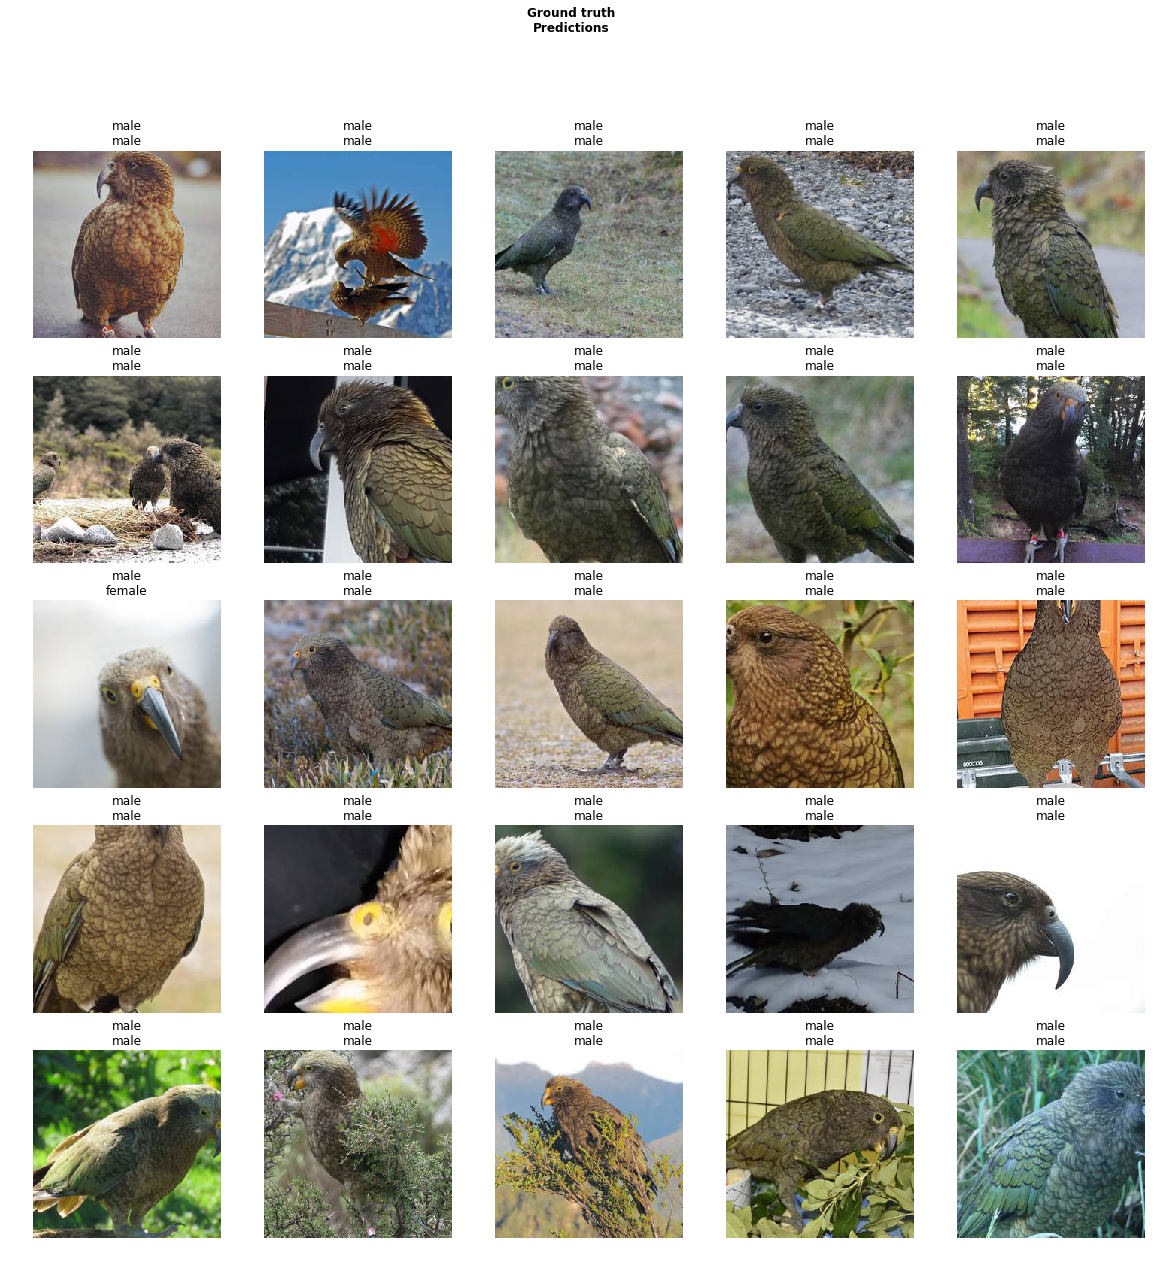

In [174]:
learn.show_results()

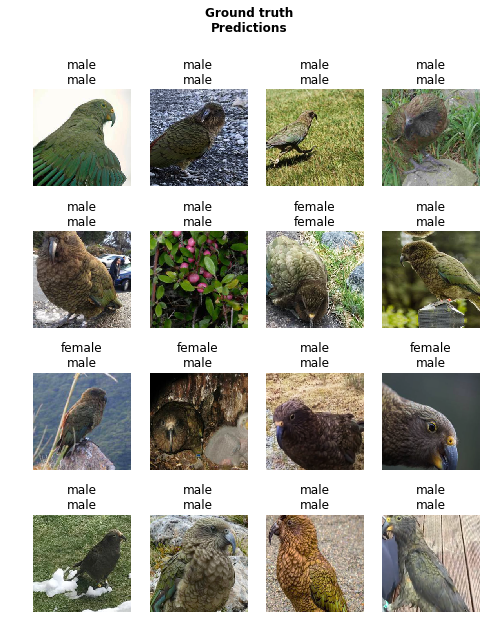

In [175]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))